In [1]:
from src import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import warnings
warnings.filterwarnings('ignore')

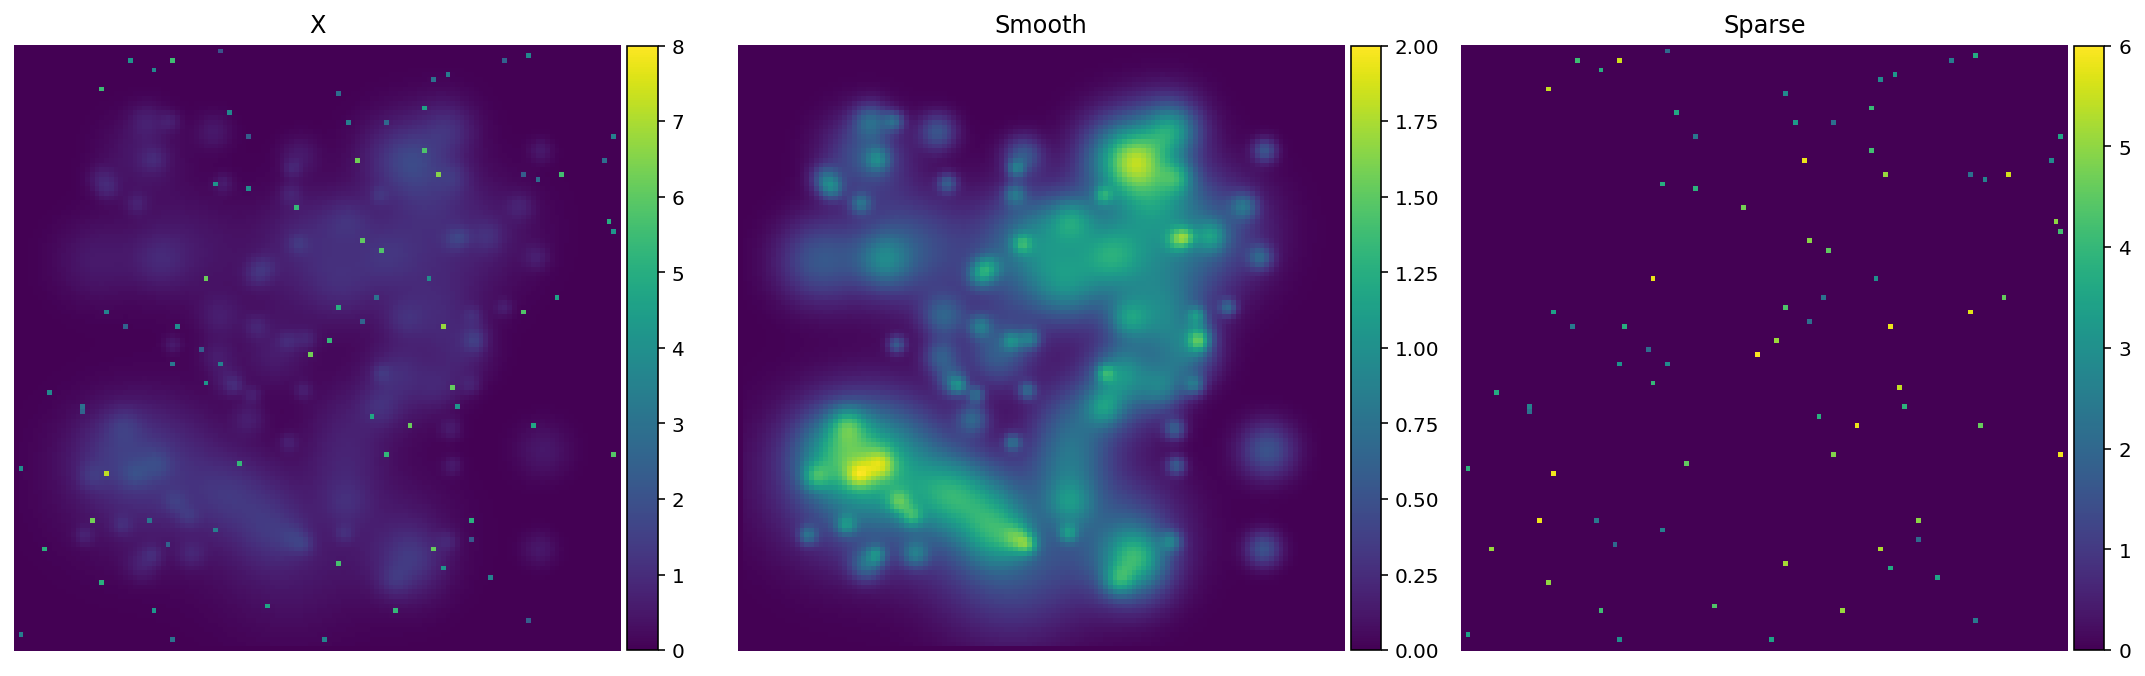

In [3]:
d = (128, 128)
seed = 42
s = SparseSmoothSignal(d)
s.random_sparse(seed)
s.random_smooth(seed)
s.plot()

In [4]:
L = 0.1
l1 = 0.02
l2 = 0.1
psnr = 50.
s.psnr = psnr
s.H = get_low_freq_operator(d, L)

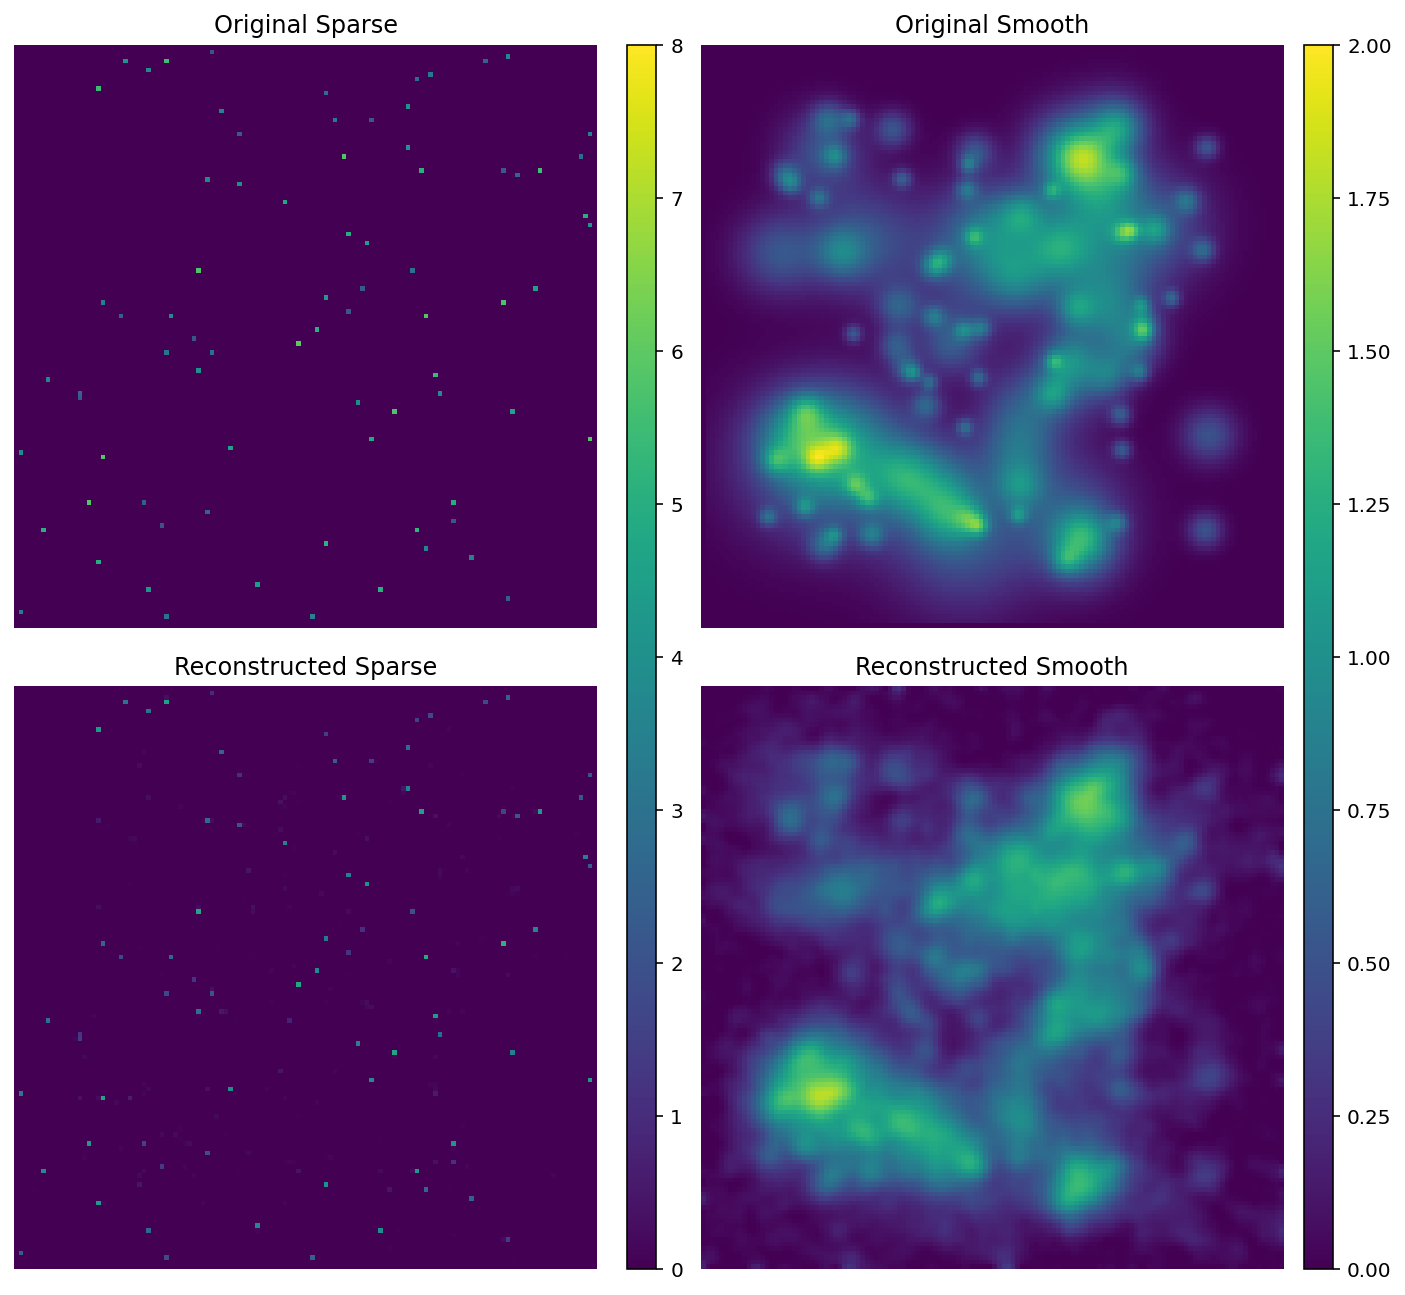

In [5]:
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)

## Sampling Methods
We have 3 different sampling methods that can be used. The first is by taking the highest fourier coeffcient of the signal x that is ploted on the left. The second is just a random uniform samping. The third is mix with a part that samples the low frequency with a gaussian and the other part samples uniformly from the rest of the pixel.

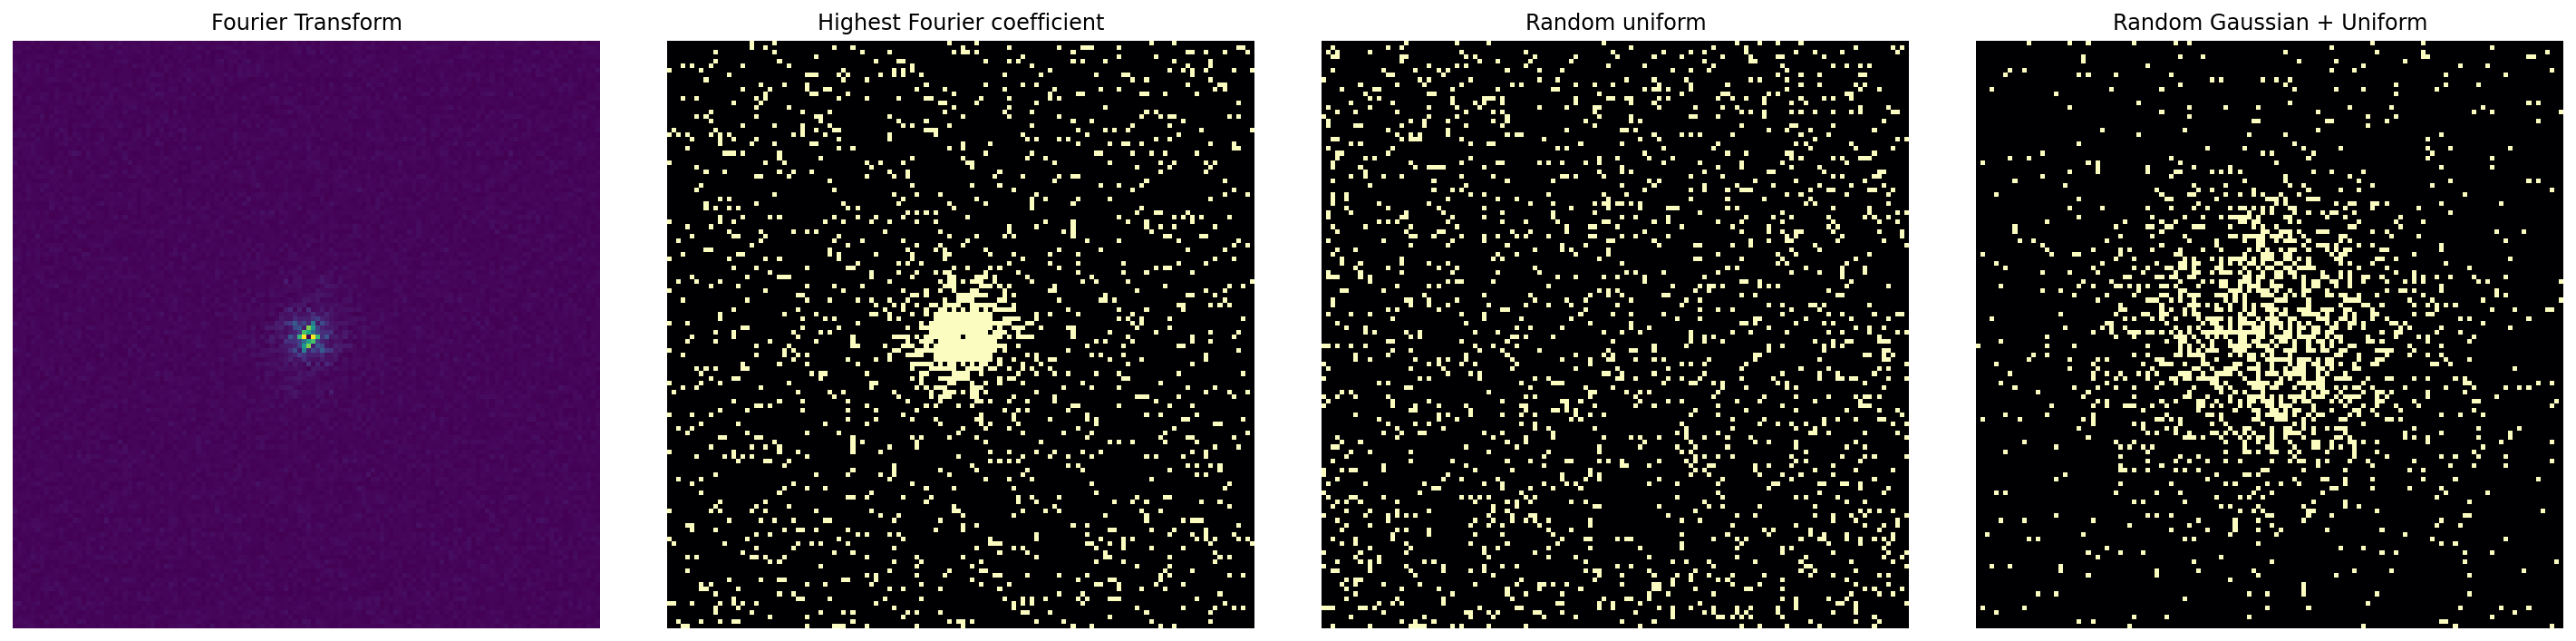

In [6]:
plot_sampling_methods(s, L)

We see that for the smooth component as long as we can sample the important coefficient we have a good reconstruction. We also notice that the sparse component is better reconstruct with a uniform sampling even slightly better than the highest fourier coeffcient.

Mean intensity of the reconstructed peaks (Highest Fourier coefficient) : 83.9%
Mean intensity of the reconstructed peaks (Random uniform) : 88.6%
Mean intensity of the reconstructed peaks (Random Gaussian + Uniform) : 70.3%


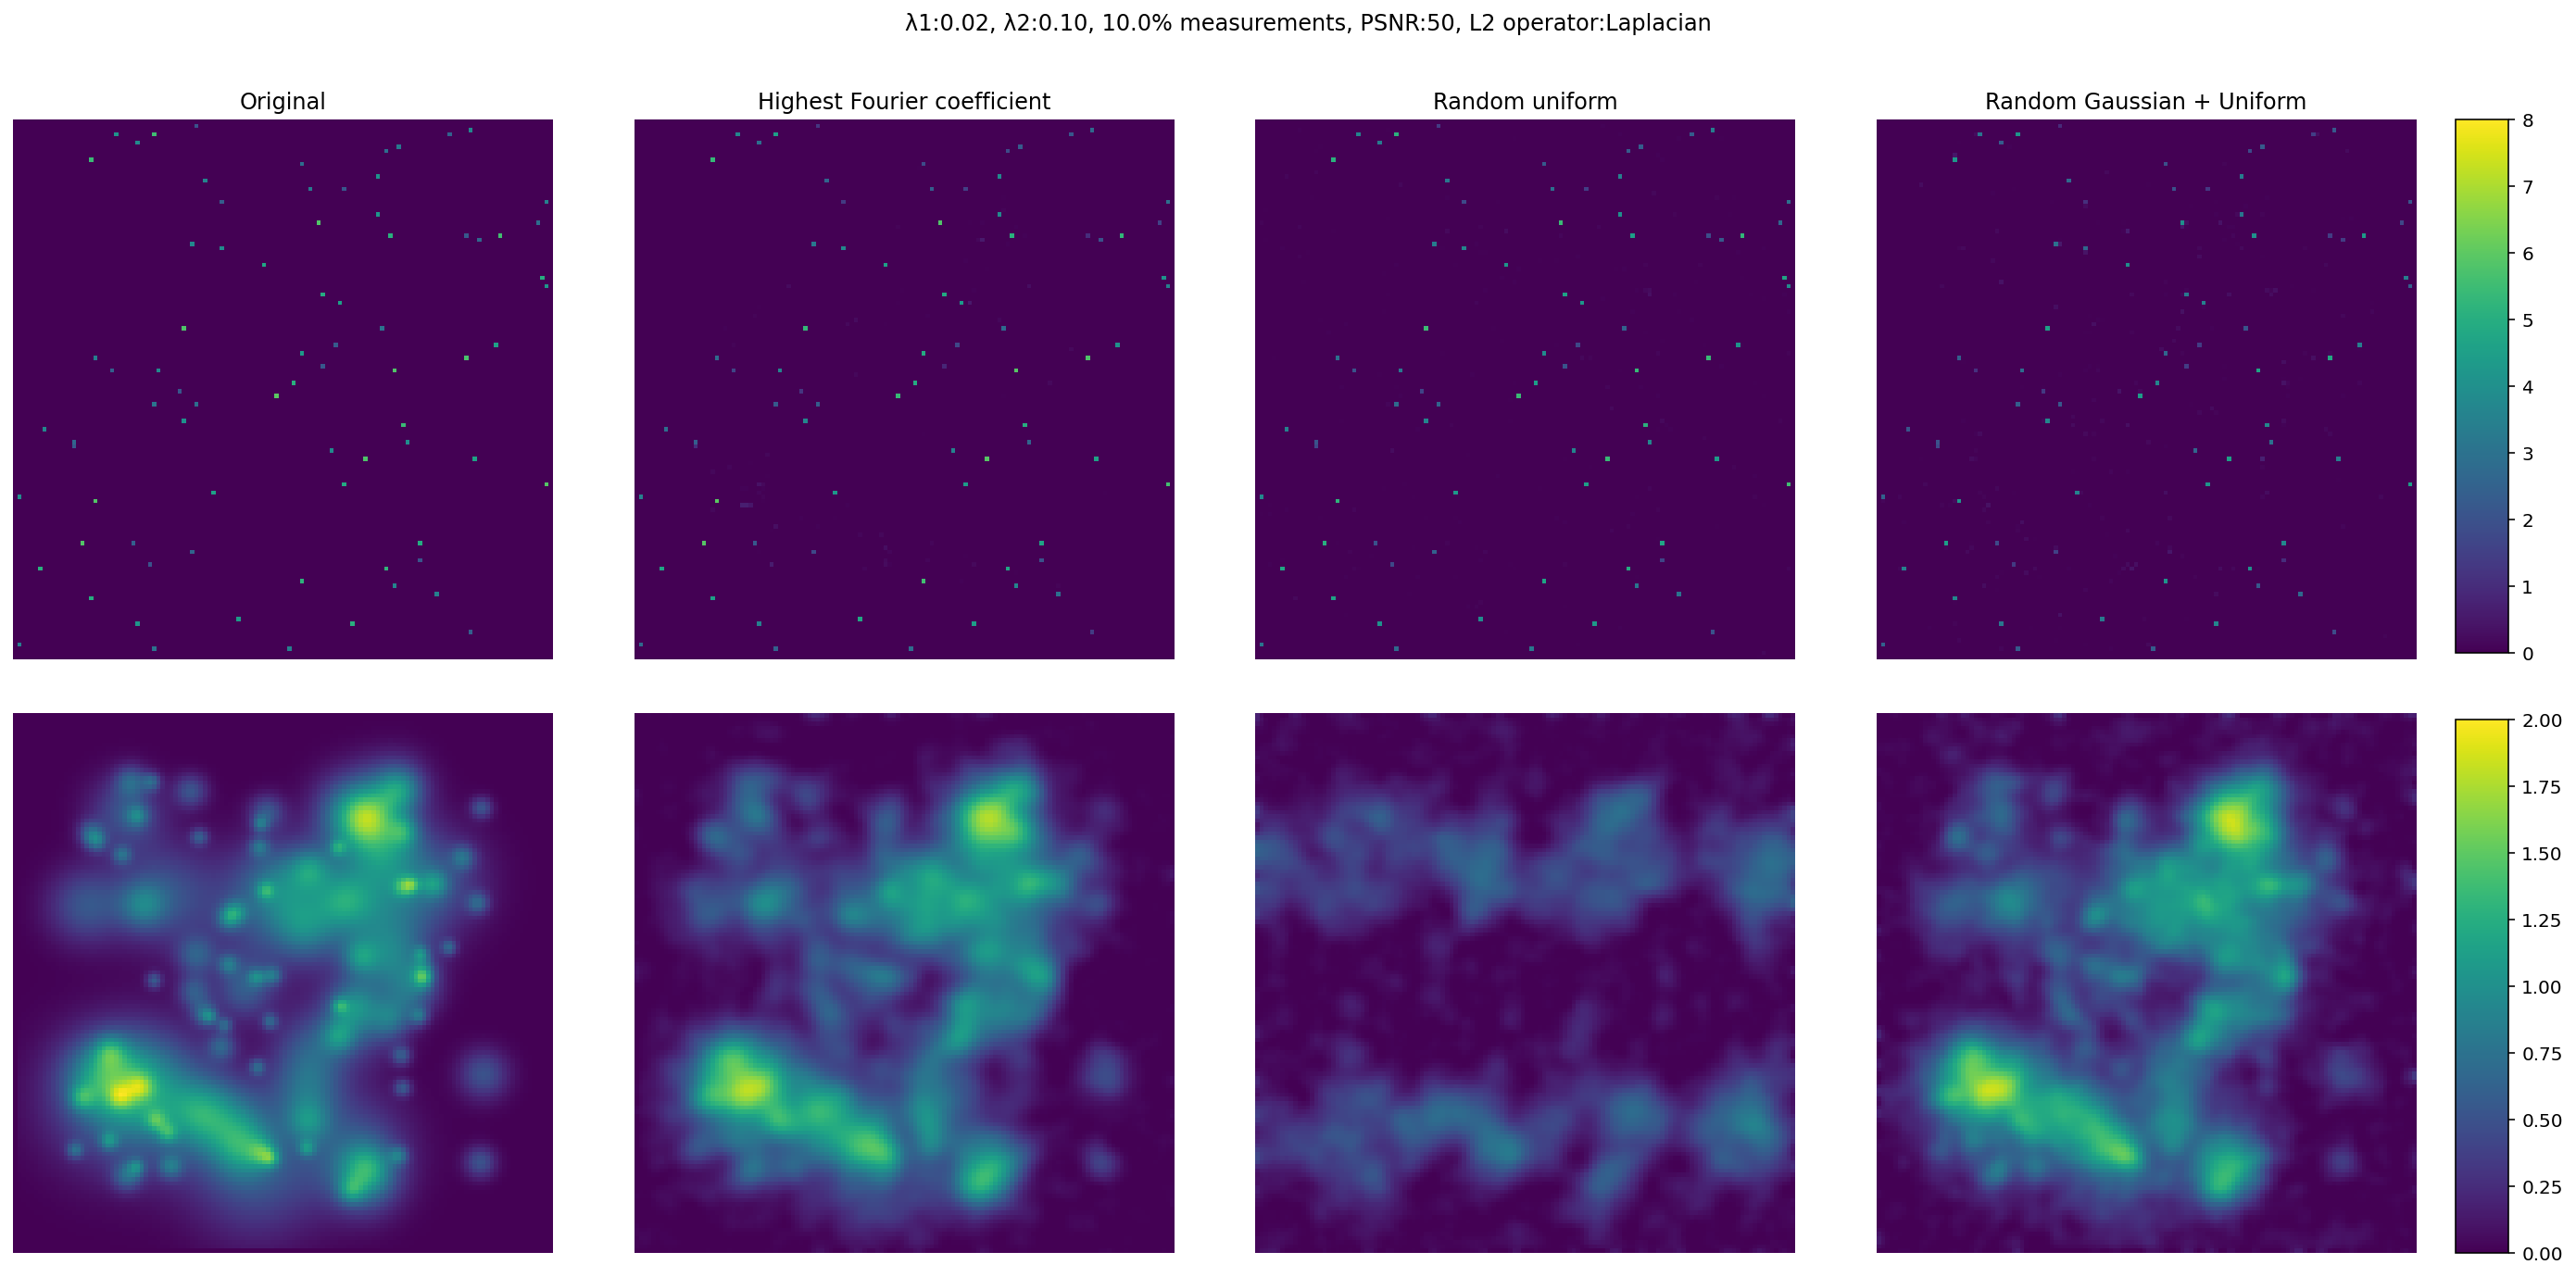

In [7]:
compare_measurements_methods(s, L, l1, l2, psnr, "Laplacian")

With noise the best methode remains the highest fourier coeffcient.

Mean intensity of the reconstructed peaks (Highest Fourier coefficient) : 38.4%
Mean intensity of the reconstructed peaks (Random uniform) : 26.3%
Mean intensity of the reconstructed peaks (Random Gaussian + Uniform) : 18.8%


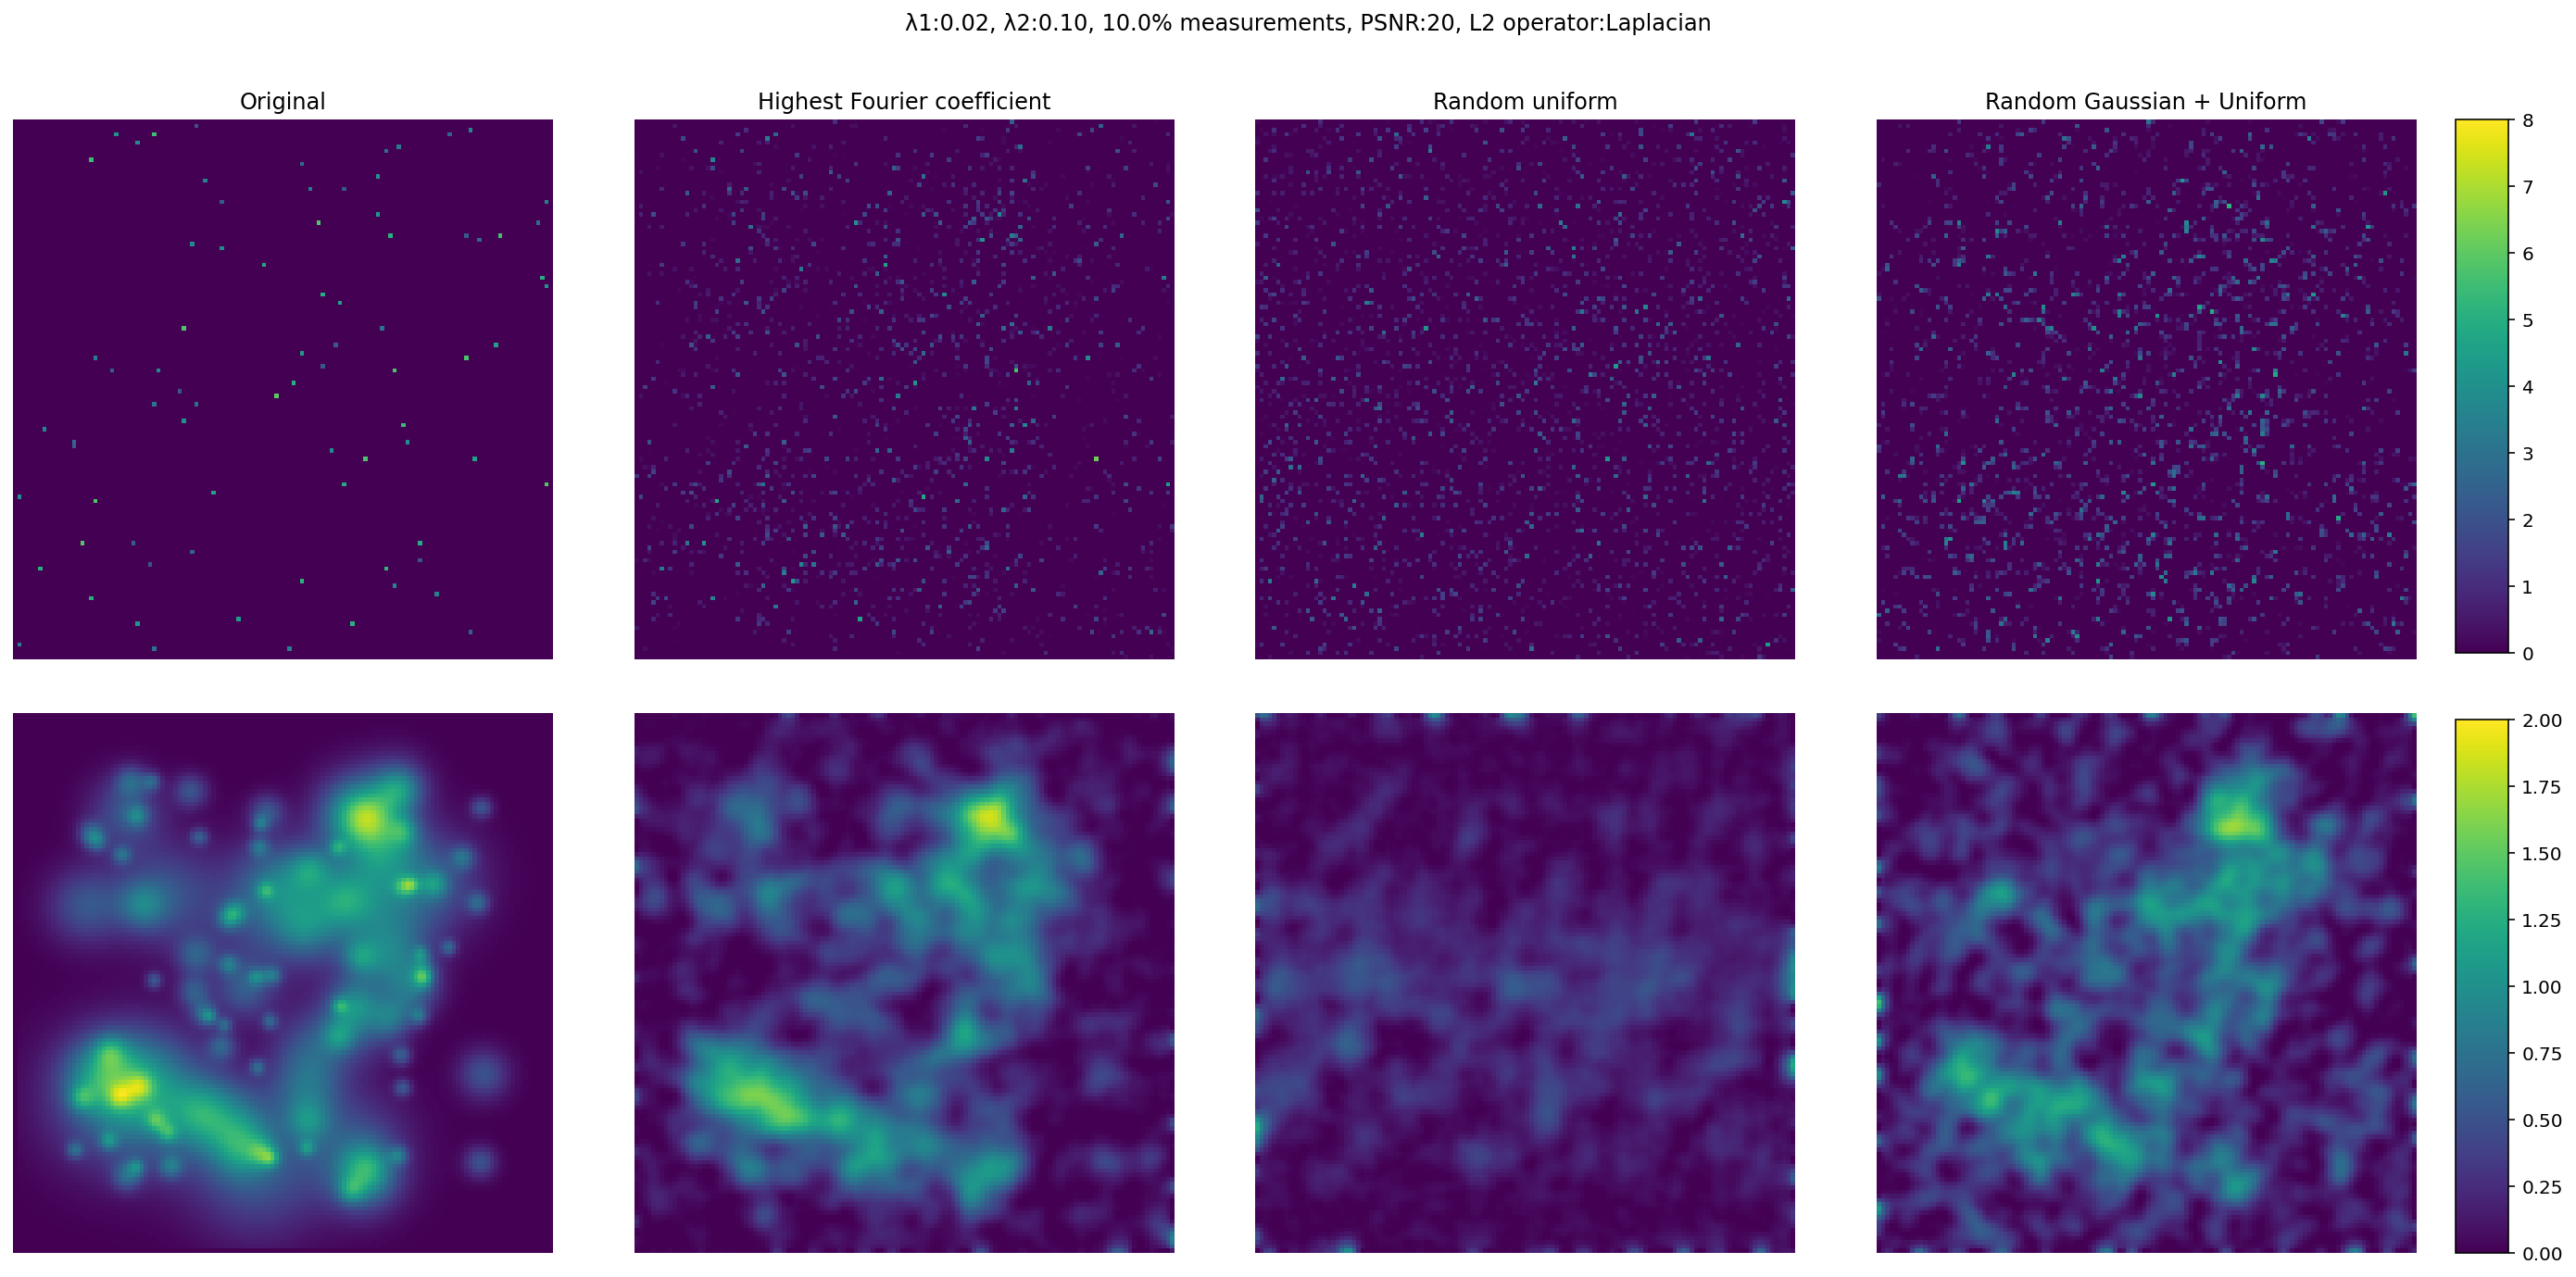

In [8]:
s.psnr = 20.
compare_measurements_methods(s, L, l1, l2, 20, "Laplacian")

The smoothing operator really help with the smooth component, it smooth the result and also eliminates the sparse component of the smooth one.

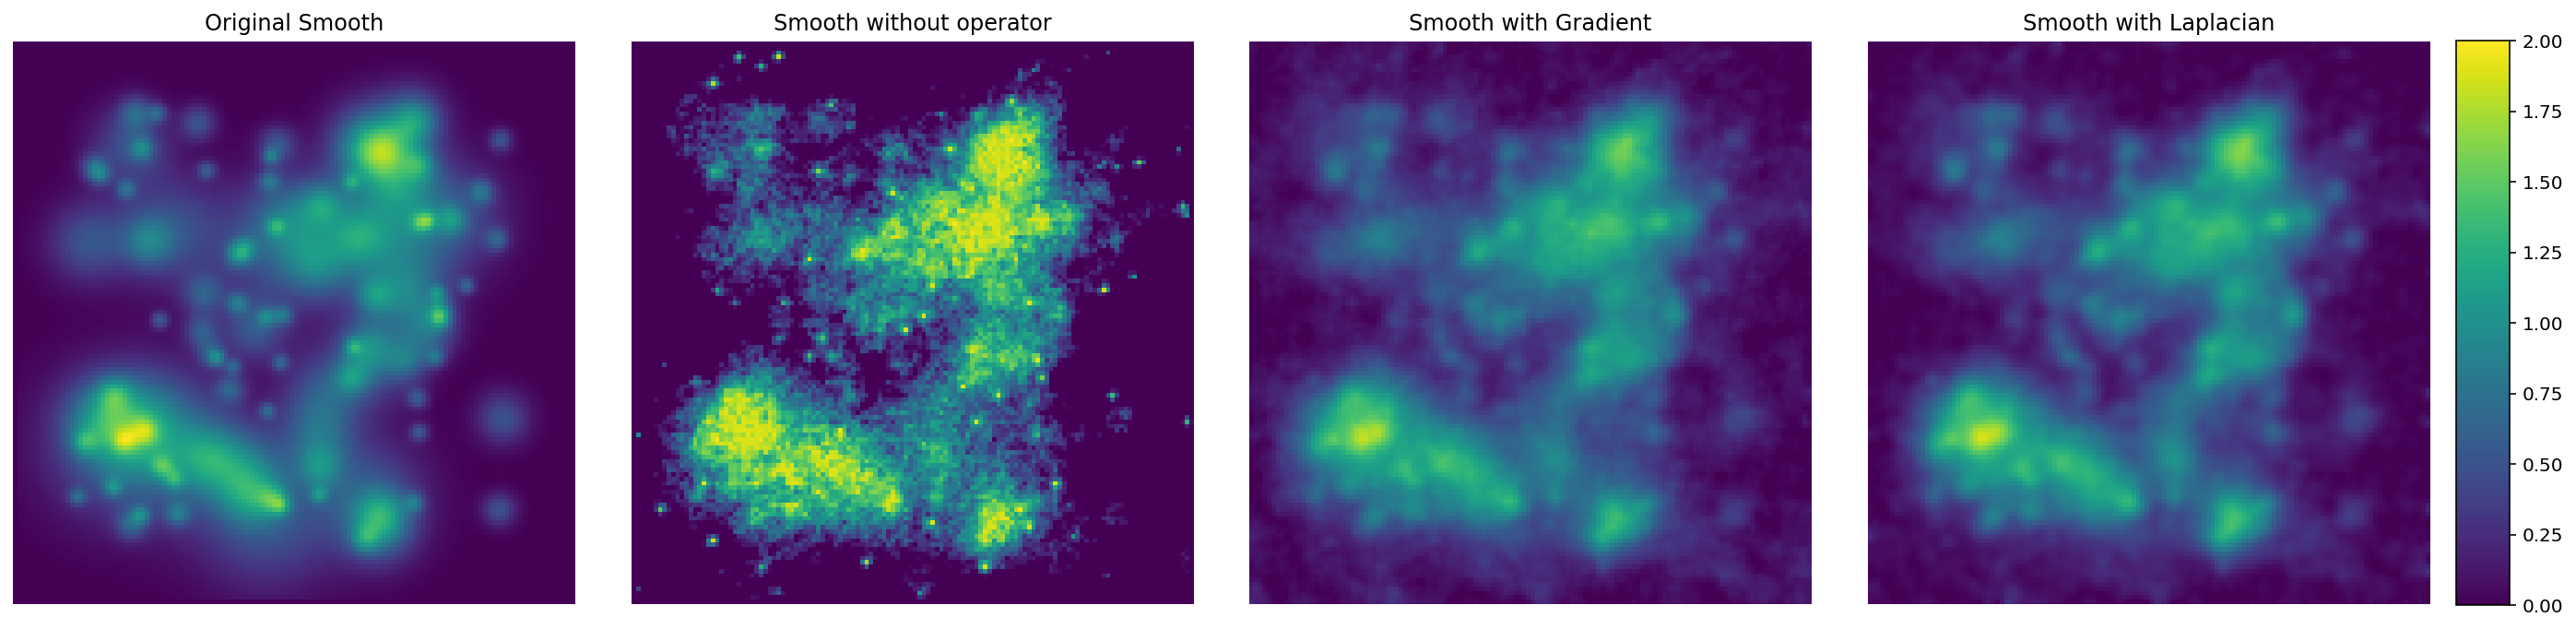

In [9]:
s.psnr = 50.
compare_smoothing_operator(s)

It works even better with when we have noise

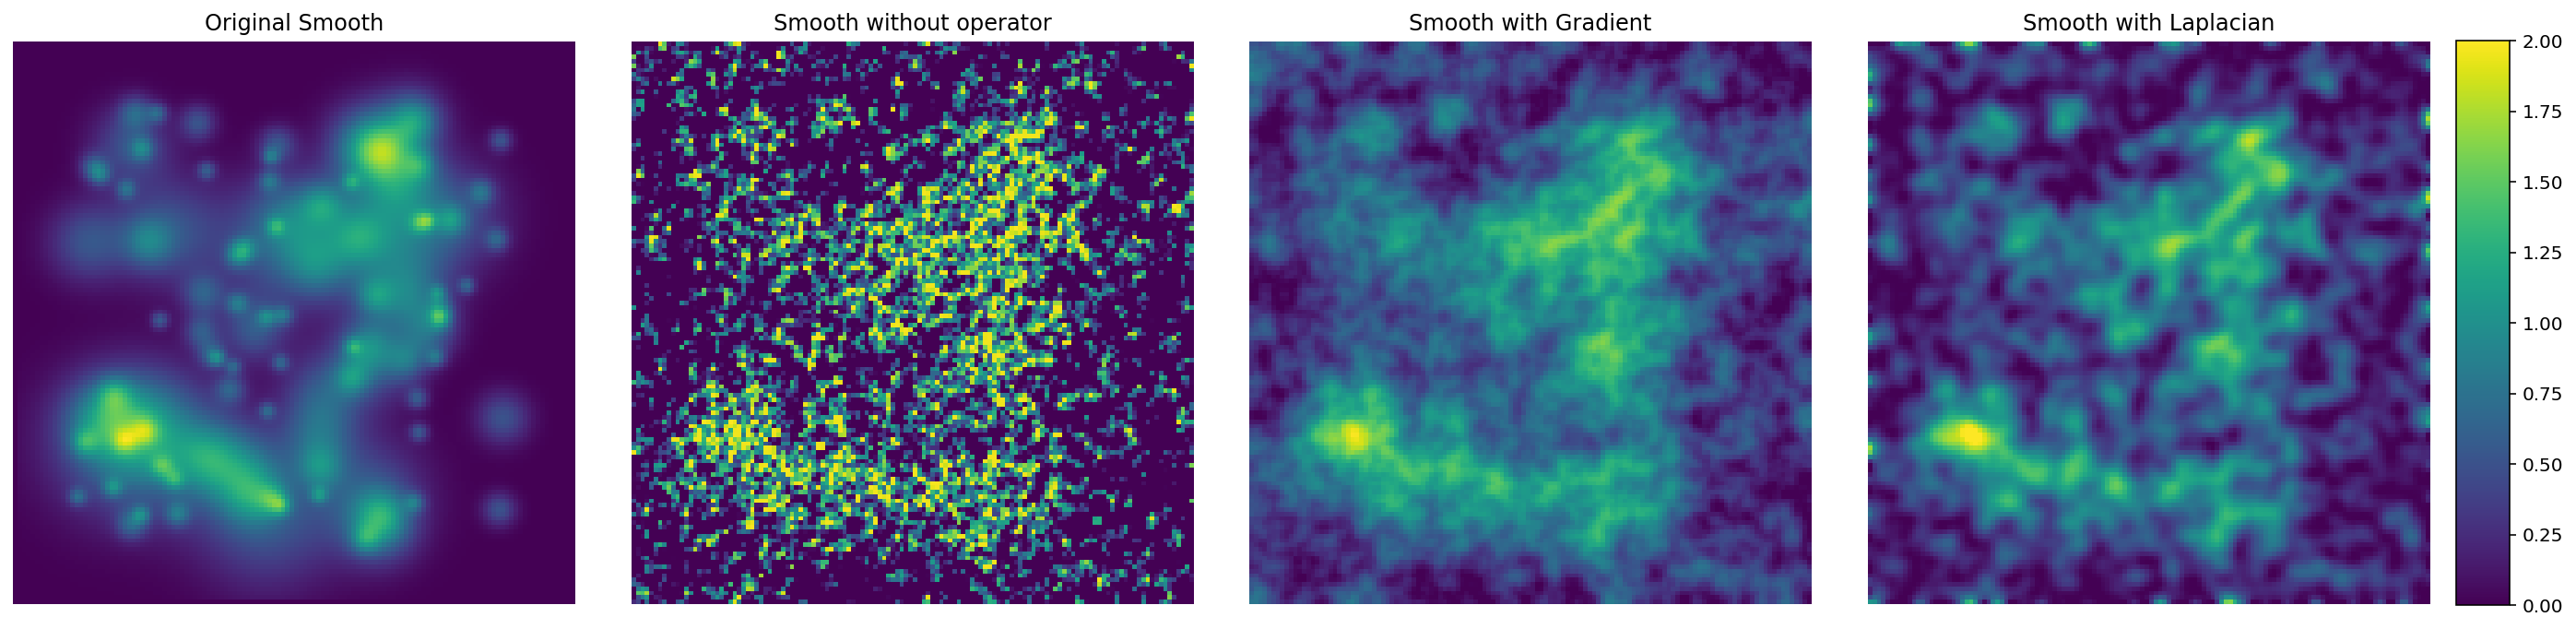

In [10]:
s.psnr = 20.
compare_smoothing_operator(s)

Best value for L1 penalty: 0.03357142857142857
Best value for L2 penalty: 0.02542857142857143


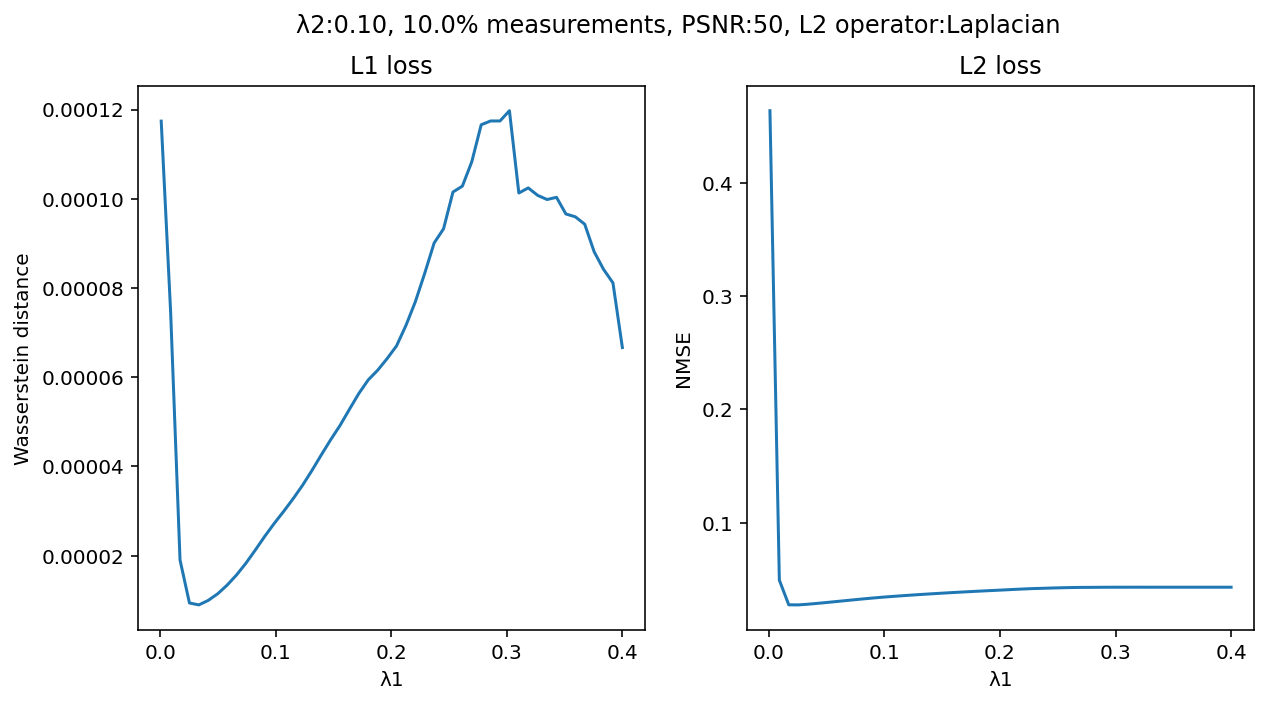

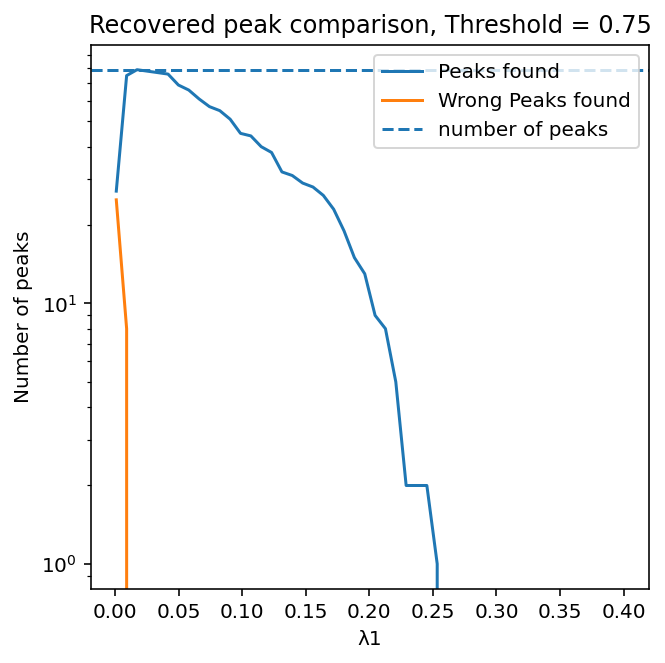

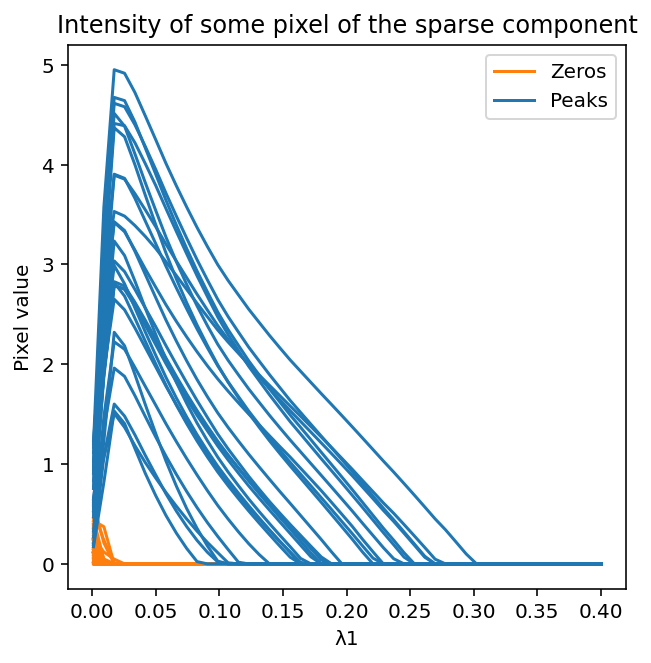

In [11]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.4, nb=50, lambda2=0.1, operator_l2="Laplacian", psnr=50., threshold=0.75)

Best value L1: 0.03357142857142857
Best value L2: 0.07428571428571429


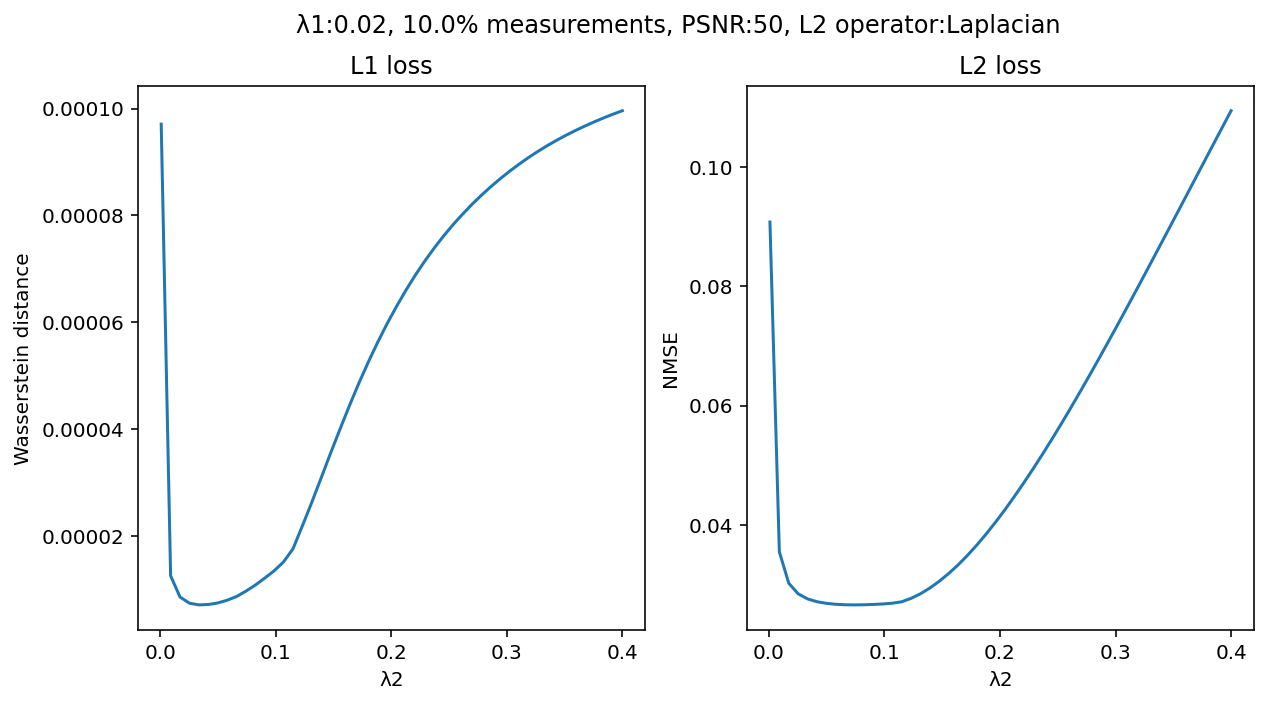

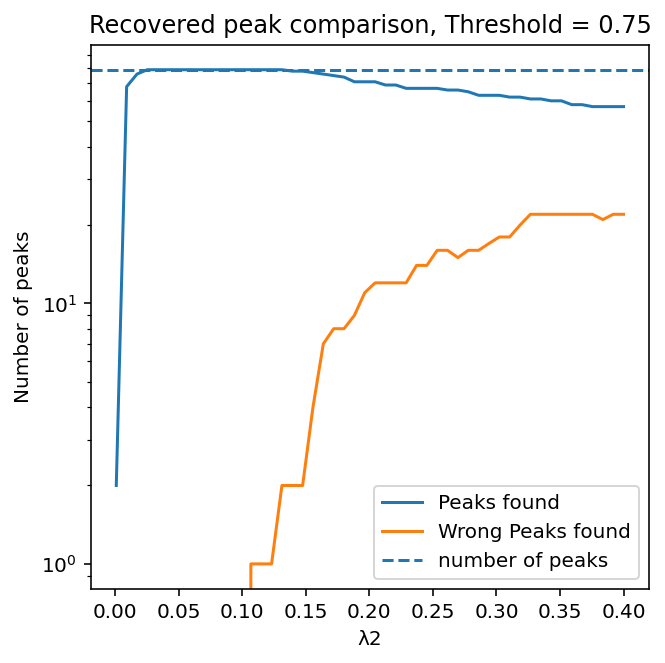

In [12]:
test_lambda2(s, L, lambda2_min=0.001, lambda2_max=0.4, nb=50, lambda1=0.02, operator_l2="Laplacian", psnr=50., threshold=0.75)

Peaks found : 52
Wrong peaks found : 308


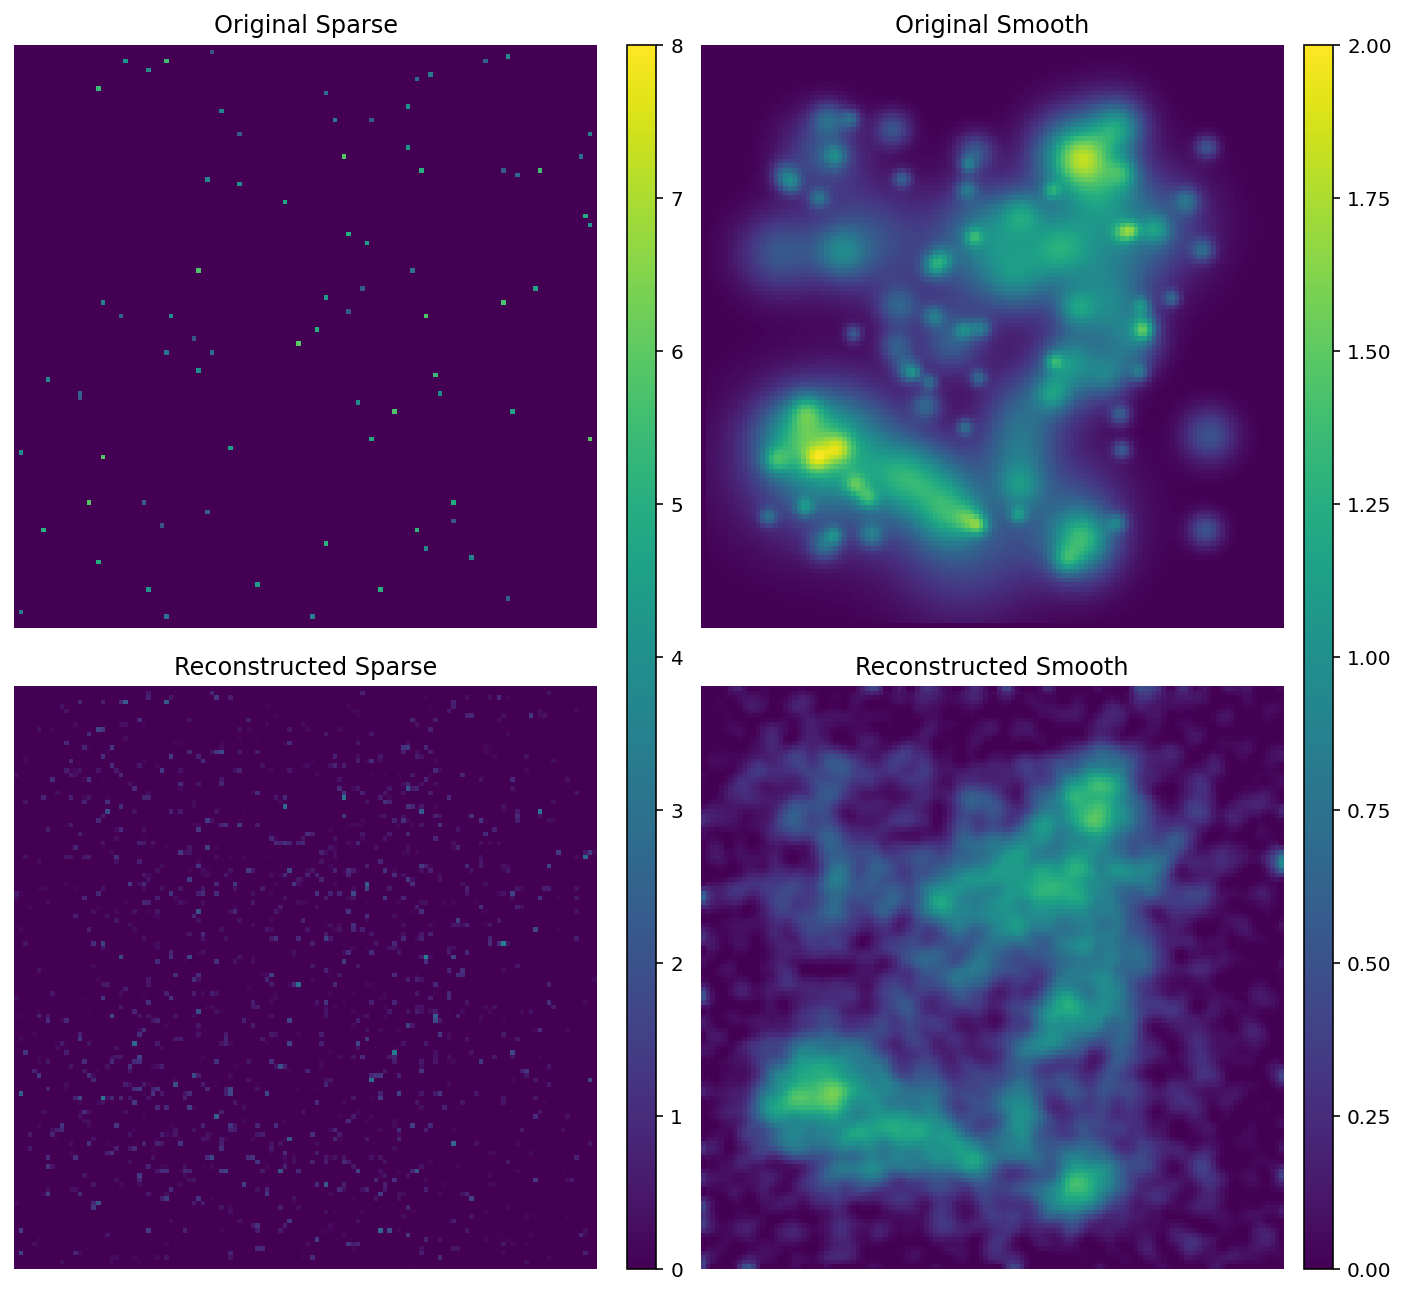

In [13]:
s.psnr = 30.
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong =  peaks_found(s.sparse, x1, 0.75)
print(f"Peaks found : {found}")
print(f"Wrong peaks found : {wrong}")

peaks found : 28
wrong peaks found : 1356


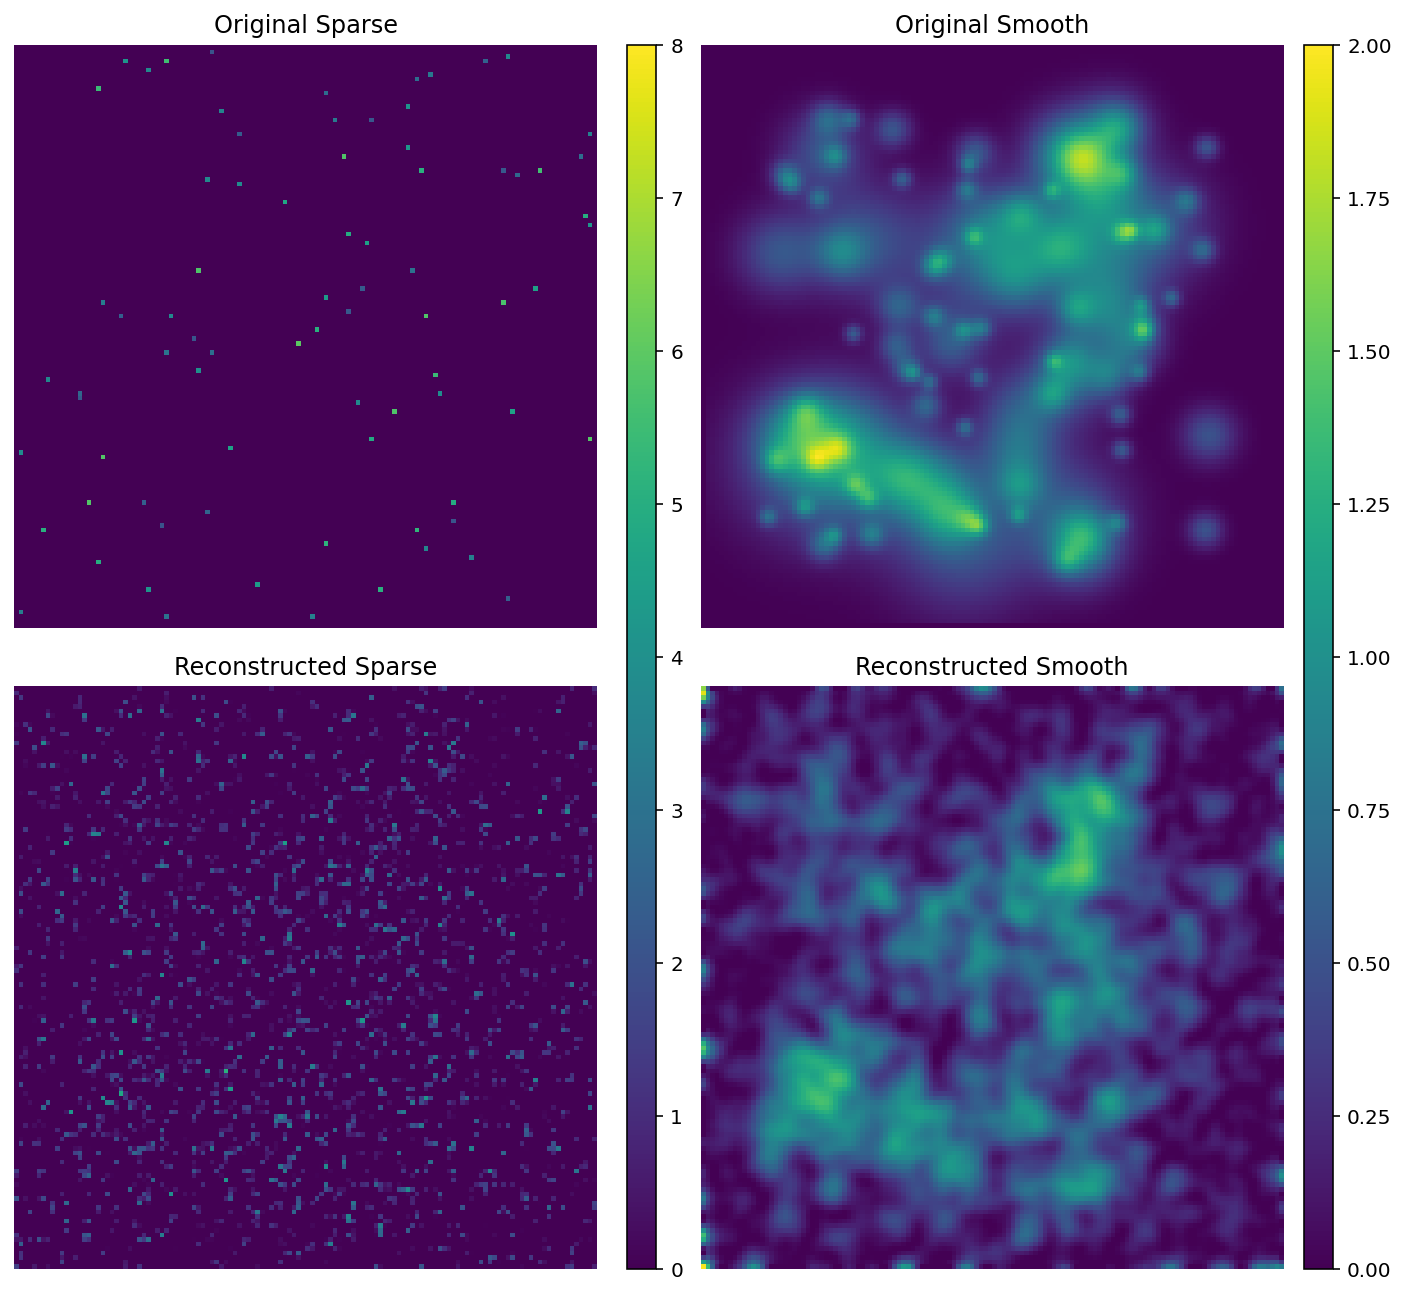

In [14]:
psnr = 20.
s.psnr = psnr
x1, x2 = solve(s, l1, l2, get_L2_operator(d, "Laplacian"))
plot_reconstruction(s.sparse, s.smooth, x1, x2)
found, wrong = peaks_found(s.sparse, x1, 0.75)
print(f"peaks found : {found}")
print(f"wrong peaks found : {wrong}")

Best value for L1 penalty: 0.2
Best value for L2 penalty: 0.021306122448979593


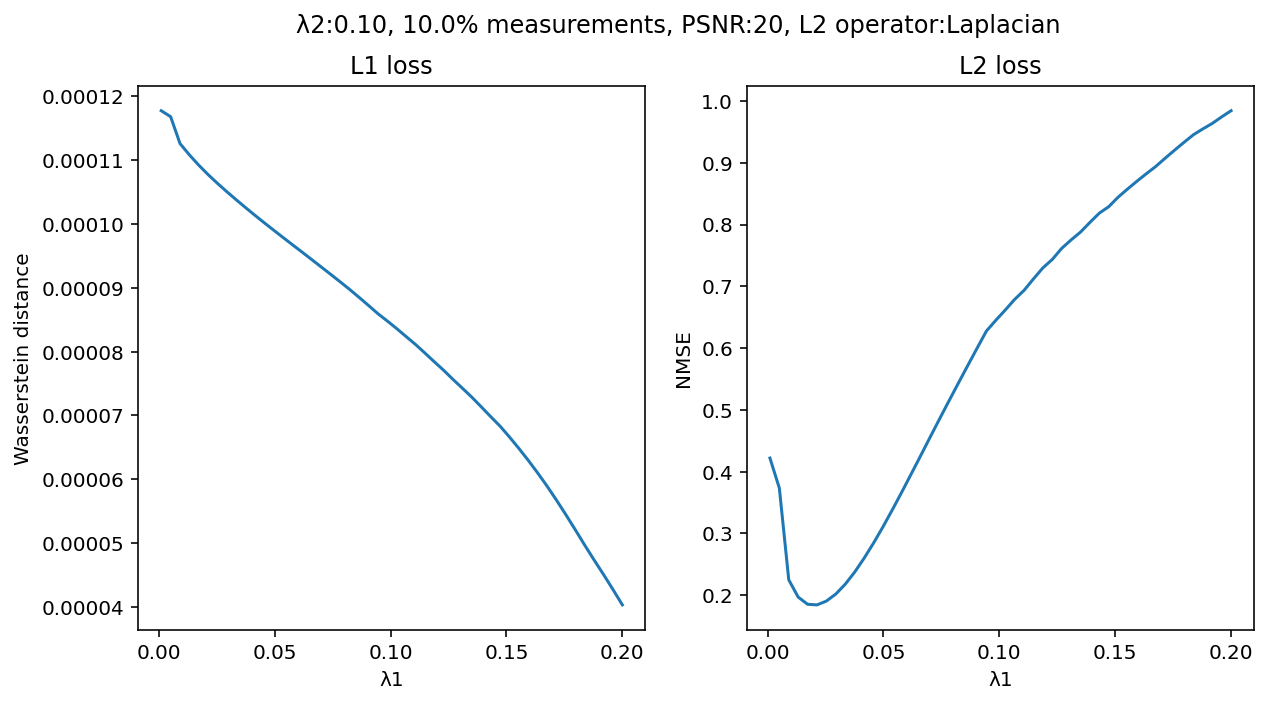

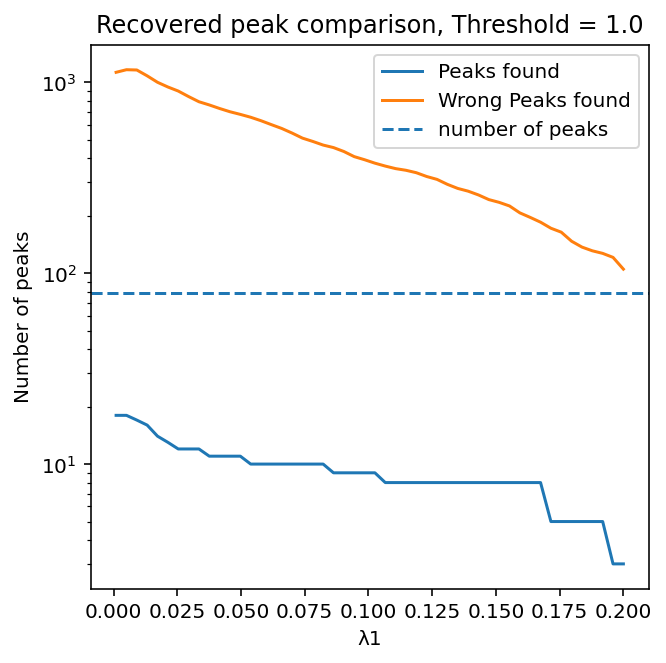

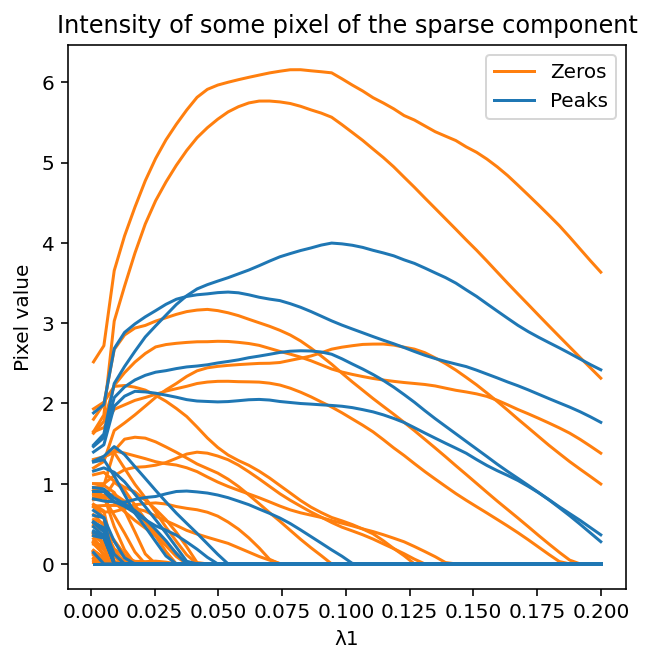

In [15]:
test_lambda1(s, L, lambda1_min=0.001, lambda1_max=0.2, nb=50, lambda2=0.1, operator_l2="Laplacian", psnr=psnr)

Best value L1: 0.005061224489795919
Best value L2: 0.2


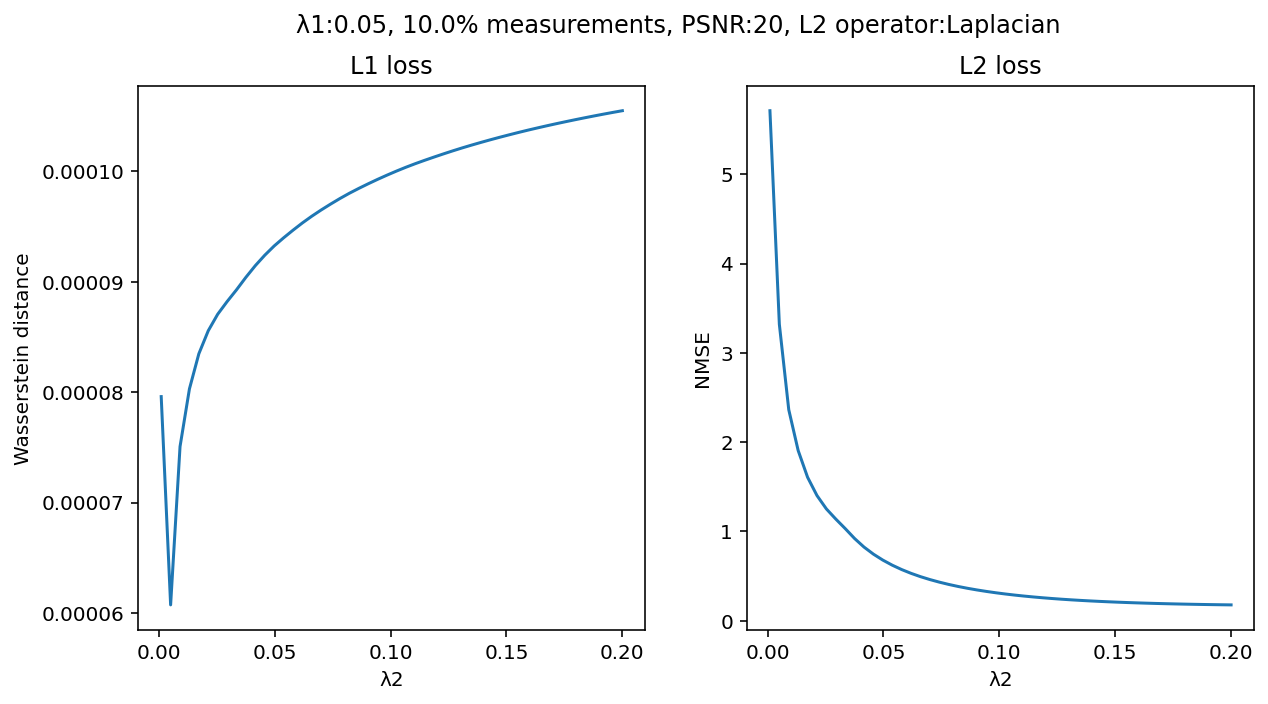

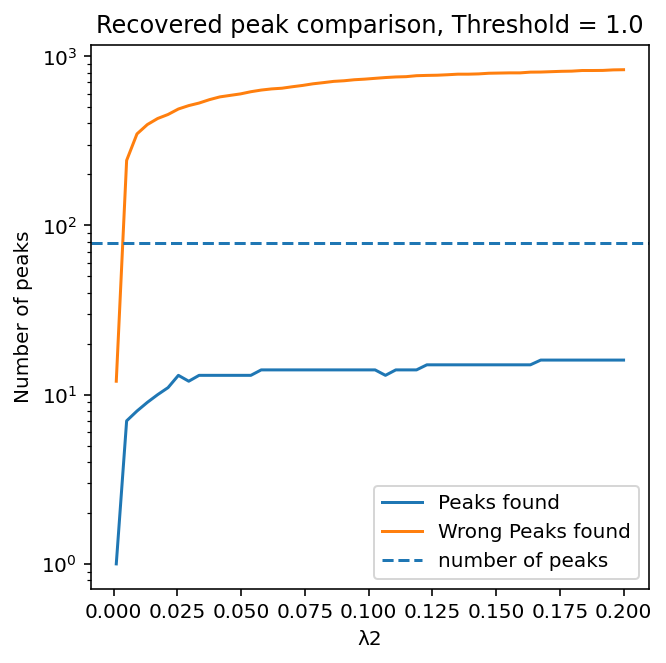

In [16]:
test_lambda2(s, L, lambda2_min=0.001, lambda2_max=0.2, nb=50, lambda1=0.05, operator_l2="Laplacian", psnr=psnr)